# 21. SHAPモデル解釈 - 説明可能なAI (SHAP Model Interpretation)

## 概要
SHAPを使って機械学習モデルの予測を解釈し、説明可能にする方法を学びます。

## 学習目標
- SHAPの基本概念を理解できる
- 特徴量の重要度を定量化できる
- 個別予測の説明ができる
- グローバルな解釈とローカルな解釈の違いを理解できる
- 実務でSHAPを活用できる

In [16]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression, load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
import shap
import warnings
warnings.filterwarnings('ignore')

# 設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

# SHAP JavaScript の初期化（ノートブック用）
shap.initjs()

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


## 1. なぜモデルの解釈が必要か

### ブラックボックス問題

複雑な機械学習モデル（Random Forest、Gradient Boosting、Neural Networksなど）は高い予測精度を持つ一方、**なぜその予測をしたのか**が分かりにくいという問題があります。

### モデル解釈が重要な理由

1. **信頼性の向上**
   - 予測根拠を理解できる
   - バイアスや誤りを検出できる

2. **規制対応**
   - 金融、医療などの分野で説明責任が求められる
   - GDPR（EU一般データ保護規則）など

3. **モデル改善**
   - 重要な特徴量を特定
   - データ収集の優先順位決定

4. **ビジネス価値**
   - 意思決定者への説明
   - アクションプランの策定

## 2. SHAPとは

### SHAP (SHapley Additive exPlanations)

ゲーム理論のShapley値に基づいた、統一的なモデル解釈手法です。

### SHAPの特徴

1. **モデル非依存**
   - あらゆる機械学習モデルに適用可能
   - 統一的な解釈フレームワーク

2. **理論的保証**
   - 数学的に厳密な基盤
   - 公平な寄与度計算

3. **ローカル＆グローバル解釈**
   - 個別予測の説明
   - 全体的なパターンの理解

### SHAP値の意味

各特徴量が予測値にどれだけ貢献したかを示す値です。

- **正のSHAP値**: 予測を増加させる方向に寄与
- **負のSHAP値**: 予測を減少させる方向に寄与
- **SHAP値の合計**: ベースライン予測からの差分

## 3. 分類問題でのSHAP

### データ準備

In [17]:
# 乳がんデータセット
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"データサイズ: {X.shape}")
print(f"\n特徴量の一部:")
print(X.columns[:10].tolist())

データサイズ: (569, 30)

特徴量の一部:
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension']


In [18]:
# モデルの学習
model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model_rf.fit(X_train, y_train)

print(f"訓練精度: {model_rf.score(X_train, y_train):.4f}")
print(f"テスト精度: {model_rf.score(X_test, y_test):.4f}")

訓練精度: 1.0000
テスト精度: 0.9561


### SHAP値の計算

In [19]:
# TreeExplainer（ツリーベースモデル用の高速explainer）
explainer = shap.TreeExplainer(model_rf)

# テストデータのSHAP値を計算
shap_values = explainer.shap_values(X_test)

# 新しいSHAPのバージョンでは形状が異なる可能性があるため確認
if isinstance(shap_values, list):
    # 古いバージョン: リスト形式
    print(f"SHAP値の形状（クラス1）: {shap_values[1].shape}")
    print(f"クラス数: {len(shap_values)}")
    shap_values_class1 = shap_values[1]
else:
    # 新しいバージョン: 3次元配列
    print(f"SHAP値の形状: {shap_values.shape}")
    if len(shap_values.shape) == 3:
        # (n_samples, n_features, n_classes)
        shap_values_class1 = shap_values[:, :, 1]
    else:
        # (n_samples, n_features) - 2クラス分類の場合
        shap_values_class1 = shap_values

print(f"\nクラス1のSHAP値形状: {shap_values_class1.shape}")
print(f"ベースライン値（期待値）: {explainer.expected_value}")

SHAP値の形状: (114, 30, 2)

クラス1のSHAP値形状: (114, 30)
ベースライン値（期待値）: [0.37551648 0.62448352]


### 4. グローバル解釈: 特徴量の重要度

全データに対する各特徴量の平均的な影響を見ます。

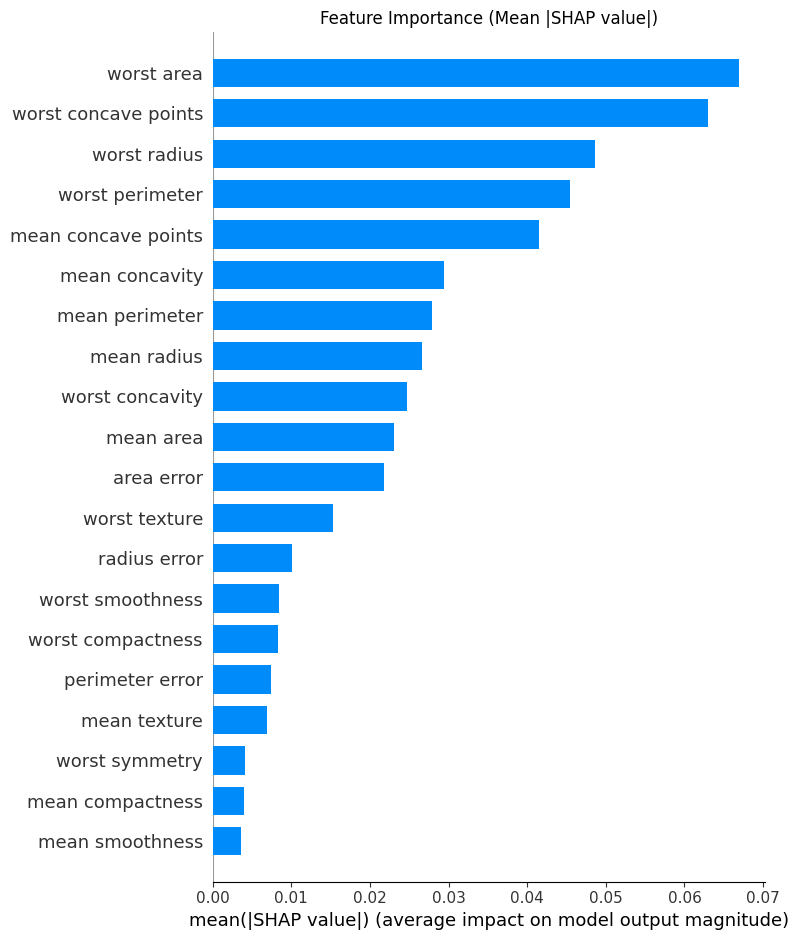

このグラフの読み方:
- 上位の特徴量ほど予測に大きく影響
- 平均絶対SHAP値で順位付け


In [20]:
# Summary Plot: 特徴量重要度と値の分布
shap.summary_plot(shap_values_class1, X_test.values, plot_type="bar", show=False, feature_names=X_test.columns.tolist())
plt.title('Feature Importance (Mean |SHAP value|)')
plt.tight_layout()
plt.show()

print("このグラフの読み方:")
print("- 上位の特徴量ほど予測に大きく影響")
print("- 平均絶対SHAP値で順位付け")

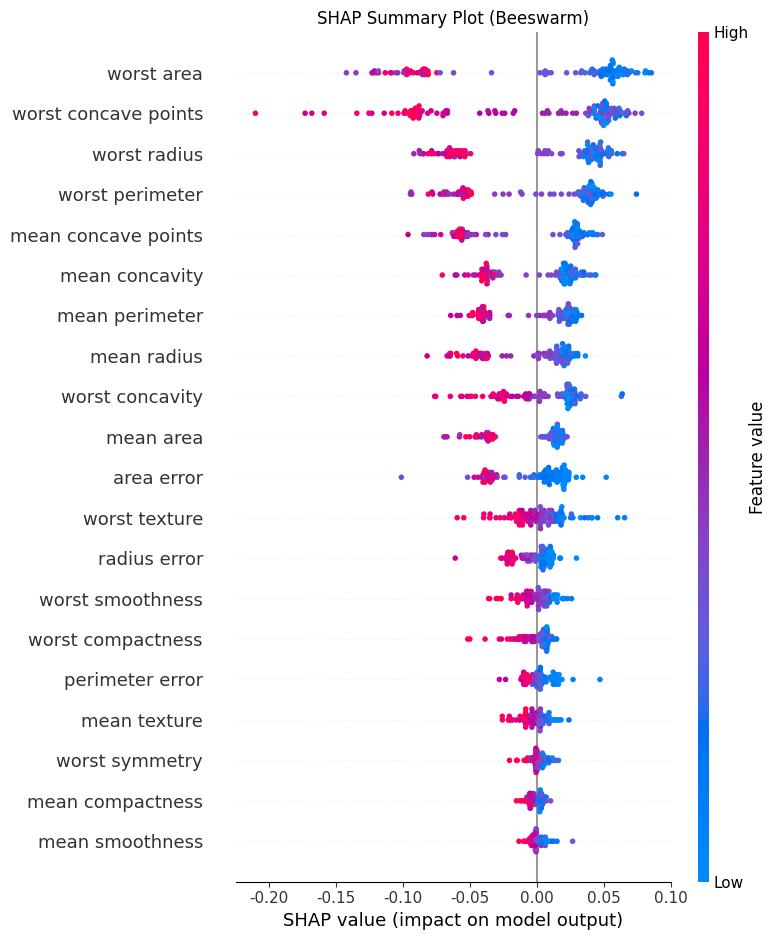


Beeswarm Plotの読み方:
- 各点が1つのサンプル
- 色: 特徴量の値（赤=高、青=低）
- X軸: SHAP値（予測への影響）
- Y軸: 特徴量（重要度順）


In [21]:
# Beeswarm Plot: 詳細な分布
shap.summary_plot(shap_values_class1, X_test.values, show=False, feature_names=X_test.columns.tolist())
plt.title('SHAP Summary Plot (Beeswarm)')
plt.tight_layout()
plt.show()

print("\nBeeswarm Plotの読み方:")
print("- 各点が1つのサンプル")
print("- 色: 特徴量の値（赤=高、青=低）")
print("- X軸: SHAP値（予測への影響）")
print("- Y軸: 特徴量（重要度順）")

### 5. ローカル解釈: 個別予測の説明

特定のサンプルに対する予測の理由を詳しく見ます。

In [22]:
# 1つのサンプルを選択
sample_idx = 0
sample = X_test.iloc[sample_idx]

# 予測
prediction = model_rf.predict([sample])[0]
probability = model_rf.predict_proba([sample])[0]

print(f"サンプル #{sample_idx}")
print(f"予測クラス: {cancer.target_names[prediction]}")
print(f"予測確率: {probability}")
print(f"実際のクラス: {cancer.target_names[y_test[sample_idx]]}")

サンプル #0
予測クラス: malignant
予測確率: [1. 0.]
実際のクラス: malignant


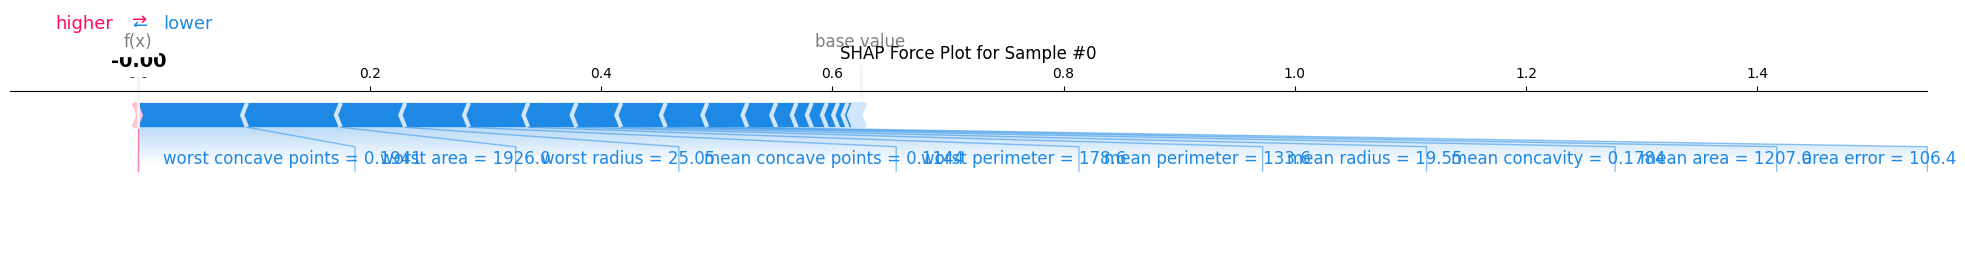


Force Plotの読み方:
- 基準値（expected value）から予測値への変化を示す
- 赤: 陽性方向に押す特徴量
- 青: 陰性方向に押す特徴量
- 幅: 影響の大きさ


In [23]:
# Force Plot: ウォーターフォール式の説明
expected_val = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
shap.force_plot(
    expected_val,
    shap_values_class1[sample_idx],
    X_test.iloc[sample_idx],
    matplotlib=True,
    show=False
)
plt.title(f'SHAP Force Plot for Sample #{sample_idx}')
plt.tight_layout()
plt.show()

print("\nForce Plotの読み方:")
print("- 基準値（expected value）から予測値への変化を示す")
print("- 赤: 陽性方向に押す特徴量")
print("- 青: 陰性方向に押す特徴量")
print("- 幅: 影響の大きさ")

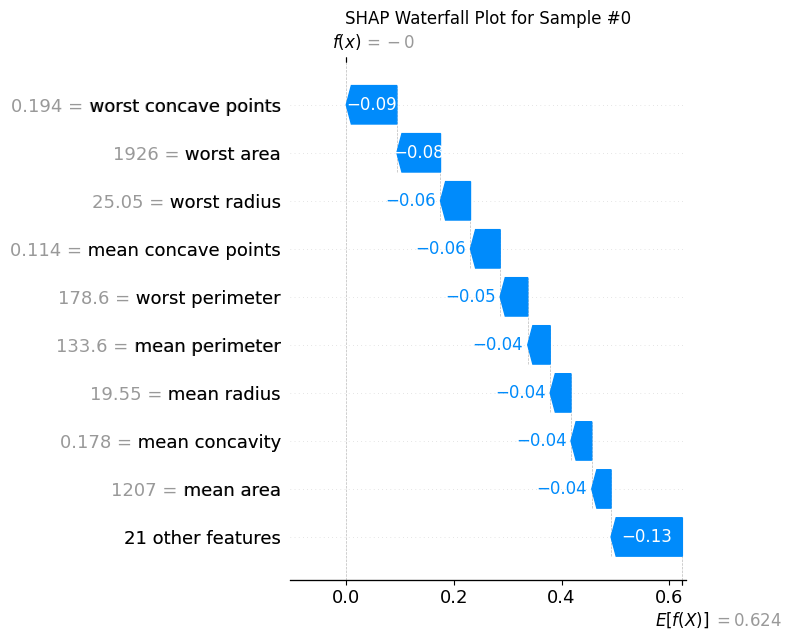

In [24]:
# Waterfall Plot: より詳細な表示
expected_val = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_class1[sample_idx],
        base_values=expected_val,
        data=X_test.iloc[sample_idx].values,
        feature_names=X_test.columns.tolist()
    ),
    show=False
)
plt.title(f'SHAP Waterfall Plot for Sample #{sample_idx}')
plt.tight_layout()
plt.show()

### 6. 依存関係プロット

特定の特徴量がどのように予測に影響するかを詳しく見ます。

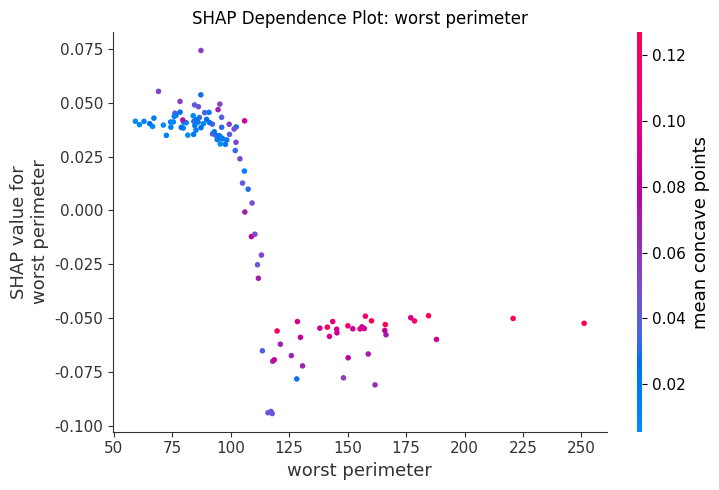


Dependence Plotの読み方:
- X軸: 特徴量の値
- Y軸: SHAP値（予測への影響）
- 色: 他の重要な特徴量の値（相互作用）
- 傾向: 特徴量と予測の関係性


In [25]:
# 最も重要な特徴量を選択
feature_name = 'worst perimeter'

# Dependence Plot
shap.dependence_plot(
    feature_name,
    shap_values_class1,
    X_test,
    show=False
)
plt.title(f'SHAP Dependence Plot: {feature_name}')
plt.tight_layout()
plt.show()

print("\nDependence Plotの読み方:")
print("- X軸: 特徴量の値")
print("- Y軸: SHAP値（予測への影響）")
print("- 色: 他の重要な特徴量の値（相互作用）")
print("- 傾向: 特徴量と予測の関係性")

## 7. 回帰問題でのSHAP

In [26]:
# Synthetic housing data (replacing fetch_california_housing due to network restrictions)
np.random.seed(42)
X_housing_synthetic, y_housing_synthetic = make_regression(
    n_samples=1000, n_features=8, n_informative=8, noise=15, random_state=42
)
# Create a namespace object to mimic the dataset structure
class SyntheticHousingData:
    def __init__(self):
        self.data = X_housing_synthetic
        self.target = y_housing_synthetic
        # Scale target to realistic housing prices
        self.target = (self.target - self.target.min()) / (self.target.max() - self.target.min()) * 4 + 0.5
        self.feature_names = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
                              'Population', 'AveOccup', 'Latitude', 'Longitude']

housing_data = SyntheticHousingData()
X_housing = pd.DataFrame(housing_data.data[:1000], columns=housing_data.feature_names)
y_housing = housing_data.target[:1000]

# データ分割
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_housing, y_housing, test_size=0.2, random_state=42
)

print(f"回帰データサイズ: {X_train_h.shape}")


回帰データサイズ: (800, 8)


In [27]:
# 回帰モデルの学習
model_gbr = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
model_gbr.fit(X_train_h, y_train_h)

# 予測精度
from sklearn.metrics import mean_squared_error, r2_score
y_pred_h = model_gbr.predict(X_test_h)
print(f"R² Score: {r2_score(y_test_h, y_pred_h):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_h, y_pred_h)):.4f}")

R² Score: 0.9056
RMSE: 0.1798


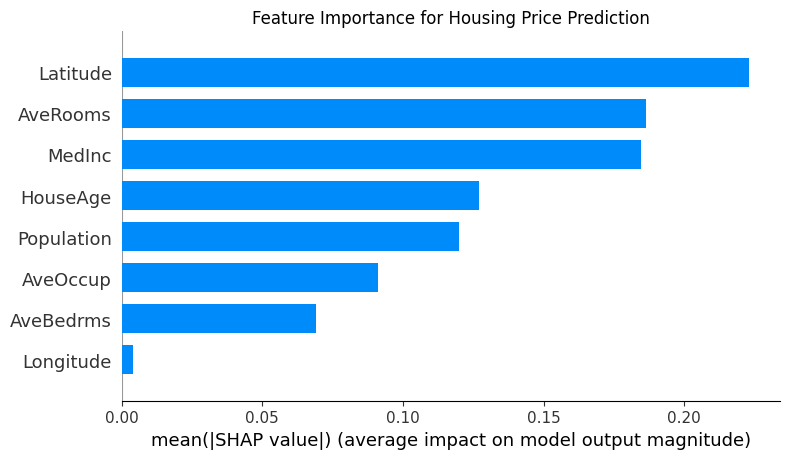

In [28]:
# SHAP値の計算
explainer_reg = shap.TreeExplainer(model_gbr)
shap_values_reg = explainer_reg.shap_values(X_test_h)

# 特徴量重要度
shap.summary_plot(shap_values_reg, X_test_h, plot_type="bar", show=False)
plt.title('Feature Importance for Housing Price Prediction')
plt.tight_layout()
plt.show()

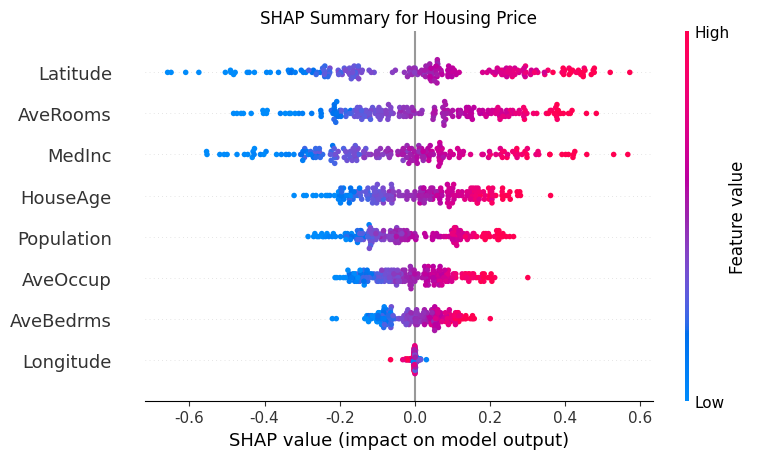


解釈例:
- MedInc（所得）が高いほど価格が上昇（正のSHAP値）
- Latitude/Longitudeの影響（地理的要因）
- 特徴量間の相互作用も可視化


In [29]:
# 詳細なSummary Plot
shap.summary_plot(shap_values_reg, X_test_h, show=False)
plt.title('SHAP Summary for Housing Price')
plt.tight_layout()
plt.show()

print("\n解釈例:")
print("- MedInc（所得）が高いほど価格が上昇（正のSHAP値）")
print("- Latitude/Longitudeの影響（地理的要因）")
print("- 特徴量間の相互作用も可視化")

## 8. 実務での活用

### ユースケース別の使い分け

In [30]:
def explain_prediction(model, explainer, sample, feature_names, target_names=None):
    """
    予測結果を詳しく説明する関数
    
    Parameters:
    -----------
    model : 学習済みモデル
    explainer : SHAP explainer
    sample : 説明したいサンプル（1次元配列）
    feature_names : 特徴量名のリスト
    target_names : クラス名のリスト（分類の場合）
    """
    # サンプルを2次元配列に変換
    sample_2d = sample.reshape(1, -1) if hasattr(sample, 'reshape') else np.array(sample).reshape(1, -1)
    
    # 予測
    prediction = model.predict(sample_2d)[0]
    
    # SHAP値
    shap_val = explainer.shap_values(sample_2d)
    
    print("=" * 60)
    print("予測結果の説明")
    print("=" * 60)
    
    if target_names is not None:
        # 分類
        proba = model.predict_proba(sample_2d)[0]
        print(f"予測クラス: {target_names[prediction]}")
        print(f"予測確率: {proba[prediction]:.4f}")
        
        # SHAP値の取得（バージョン互換性対応）
        if isinstance(shap_val, list):
            shap_class1 = shap_val[1][0]
        elif len(shap_val.shape) == 3:
            shap_class1 = shap_val[0, :, 1]
        else:
            shap_class1 = shap_val[0]
        
        shap_abs = np.abs(shap_class1)
    else:
        # 回帰
        print(f"予測値: {prediction:.4f}")
        if isinstance(shap_val, list):
            shap_abs = np.abs(shap_val[0])
        else:
            shap_abs = np.abs(shap_val[0])
    
    # 重要な特徴量トップ5
    top_indices = np.argsort(shap_abs)[-5:][::-1]
    
    print("\n影響の大きい特徴量 TOP 5:")
    for i, idx in enumerate(top_indices, 1):
        if target_names is not None:
            shap_value = shap_class1[idx]
        else:
            if isinstance(shap_val, list):
                shap_value = shap_val[0][idx]
            else:
                shap_value = shap_val[0][idx]
        
        direction = "↑" if shap_value > 0 else "↓"
        print(f"{i}. {feature_names[idx]}: {sample[idx]:.2f}")
        print(f"   SHAP値: {shap_value:.4f} {direction}")
    
    print("=" * 60)

# 使用例
explain_prediction(
    model_rf, 
    explainer, 
    X_test.iloc[0].values,
    X_test.columns.tolist(),
    cancer.target_names
)

予測結果の説明
予測クラス: malignant
予測確率: 1.0000

影響の大きい特徴量 TOP 5:
1. worst concave points: 0.19
   SHAP値: -0.0940 ↓
2. worst area: 1926.00
   SHAP値: -0.0811 ↓
3. worst radius: 25.05
   SHAP値: -0.0557 ↓
4. mean concave points: 0.11
   SHAP値: -0.0551 ↓
5. worst perimeter: 178.60
   SHAP値: -0.0513 ↓


## 9. まとめ

### 本ノートブックで学んだこと

1. **モデル解釈の重要性**
   - ブラックボックス問題
   - 信頼性、規制対応、ビジネス価値

2. **SHAPの基礎**
   - Shapley値に基づく統一的手法
   - 理論的保証と実用性

3. **グローバル解釈**
   - 特徴量重要度
   - Summary plot
   - 全体的なパターン理解

4. **ローカル解釈**
   - 個別予測の説明
   - Force plot、Waterfall plot
   - 予測根拠の可視化

5. **依存関係分析**
   - Dependence plot
   - 特徴量と予測の関係
   - 相互作用の発見

6. **実務での活用**
   - 分類・回帰両方での適用
   - カスタム説明関数
   - レポート自動生成

### SHAPを使うべきとき

- ✅ モデルの信頼性を高めたい
- ✅ ステークホルダーへの説明が必要
- ✅ 規制対応が求められる
- ✅ 特徴量エンジニアリングの改善
- ✅ バイアスや誤りの検出

### 次のステップ

- Notebook 22でStackingアンサンブルを学ぶ
- 実際のプロジェクトでSHAPを活用
- より高度な解釈手法を探求（LIME、Integrated Gradientsなど）